In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation3/"
mask_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation3/"

img_val_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation0/"
mask_val_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation0/"

In [ ]:
!pip install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from skimage.transform import resize
from tqdm.notebook import tqdm 
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from PIL import Image
import tensorflow as tf
import segmentation_models as sm
from keras import backend as K
import albumentations as A

Segmentation Models: using `tf.keras` framework.


In [ ]:
print("Number of dataset:", len(os.listdir(img_path)))
print("Number of ground truth:", len(os.listdir(mask_path)))

Number of dataset: 1600
Number of ground truth: 1600


In [ ]:
print("Number of dataset:", len(os.listdir(img_val_path)))
print("Number of ground truth:", len(os.listdir(mask_val_path)))

Number of dataset: 400
Number of ground truth: 400


image shape: (450, 480, 3)
masked shape: (450, 480, 3)


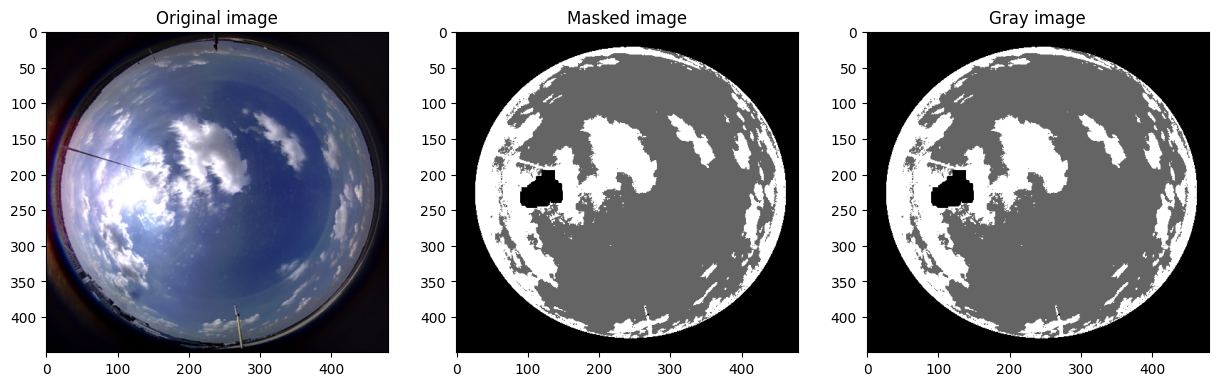

In [ ]:
ex_img = cv2.imread("/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation3/ASC100-1006_001_augmented_2.jpg")
print("image shape:", ex_img.shape)

mask_ex_img = cv2.imread("/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation3/ASC100-1006_001_augmented_2.png")
print("masked shape:", mask_ex_img.shape)

f, (axz1, axz2, axz3) = plt.subplots(1,3, figsize=(15, 15))
axz1.imshow(cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB))
axz1.title.set_text("Original image")
axz2.imshow(mask_ex_img)
axz2.title.set_text("Masked image")
axz3.imshow(cv2.cvtColor(mask_ex_img, cv2.COLOR_BGR2GRAY), cmap="gray")
axz3.title.set_text("Gray image")
plt.show()

In [ ]:
np.unique(mask_ex_img)

array([  0, 100, 255], dtype=uint8)

In [ ]:
SIZE_X = 224
SIZE_Y = 224
n_classes = 3

In [ ]:
## Train image
train_images = []

for file in tqdm(sorted(os.listdir(img_path))):
    filename = img_path + file
    img = cv2.imread(filename)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    train_images.append(img)

train_images = np.array(train_images)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [ ]:
## Train mask
train_masks = []

for file in tqdm(sorted(os.listdir(mask_path))):
    filename = mask_path + file
    img = cv2.imread(filename)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train_masks.append(img)
    # print(np.unique(np.array(img)))

train_masks = np.array(train_masks)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [ ]:
## Val and Test image
test_images = []

for file in tqdm(sorted(os.listdir(img_val_path))):
    filename = img_val_path + file
    img = cv2.imread(filename)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    test_images.append(img)

test_images = np.array(test_images)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
## Val and Test image
test_masks = []

for file in tqdm(sorted(os.listdir(mask_val_path))):
    filename = mask_val_path + file
    img = cv2.imread(filename)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test_masks.append(img)

test_masks = np.array(test_masks)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
## Train
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
print(len(np.unique(train_masks_encoded_original_shape)))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2]
3


In [ ]:
## Val
labelencoder = LabelEncoder()
n, h, w = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1, 1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(test_masks_encoded_original_shape))
print(len(np.unique(test_masks_encoded_original_shape)))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2]
3


In [ ]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)

In [ ]:
X_test = test_images
y_test = test_masks_input

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size=0.2, random_state = 42)

In [ ]:
print("Train set:", X_train.shape[0])
print("Validation set:", X_val.shape[0])
print("Test set:", X_test.shape[0])

Train set: 1280
Validation set: 320
Test set: 400


In [ ]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [ ]:
val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [ ]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

224
224
3


In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
metrics=['accuracy', jacard_coef]

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)
X_test_prepr = preprocess_input(X_test)

In [ ]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax', encoder_freeze=True)

In [ ]:
opt = tf.keras.optimizers.AdamW(learning_rate=3e-4)
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_jacard_coef', factor=0.2,patience=15, min_lr=1e-5)

In [ ]:
# checkpoint_filepath = '/content/drive/MyDrive/senior/cloud segmentations/cloudSeg_model/model-cloud-seg-resnet34-aug3-adamw-500-1e_46.h5'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     # save_weights_only=True,
#     monitor='val_jacard_coef',
#     mode='max',
#     save_best_only=True)

In [ ]:
history = model_resnet_backbone.fit(X_train_prepr, y_train_cat, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=60, 
                    validation_data=(X_val_prepr, y_val_cat))
                    # callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/60
320/320 [==============================] - 32s 34ms/step - loss: 0.2555 - accuracy: 0.9054 - jacard_coef: 0.7312 - val_loss: 0.7126 - val_accuracy: 0.6106 - val_jacard_coef: 0.4046
Epoch 2/60
320/320 [==============================] - 9s 29ms/step - loss: 0.1456 - accuracy: 0.9450 - jacard_coef: 0.8408 - val_loss: 0.5170 - val_accuracy: 0.8184 - val_jacard_coef: 0.5483
Epoch 3/60
320/320 [==============================] - 9s 29ms/step - loss: 0.1263 - accuracy: 0.9518 - jacard_coef: 0.8627 - val_loss: 0.1635 - val_accuracy: 0.9445 - val_jacard_coef: 0.8195
Epoch 4/60
320/320 [==============================] - 9s 29ms/step - loss: 0.1079 - accuracy: 0.9587 - jacard_coef: 0.8808 - val_loss: 0.1009 - val_accuracy: 0.9617 - val_jacard_coef: 0.8761
Epoch 5/60
320/320 [==============================] - 9s 29ms/step - loss: 0.0985 - accuracy: 0.9617 - jacard_coef: 0.8915 - val_loss: 0.0920 - val_accuracy: 0.9638 - val_jacard_coef: 0.8955
Epoch 6/60
320/320 [========================

In [ ]:
loss, acc, jacard_coef  = model_resnet_backbone.evaluate(X_test, y_test_cat)
print("Loss : ", loss)
print("Accuracy : ", (acc * 100.0), "%")
print("Jacard coef : ", (jacard_coef * 100.0), "%")

13/13 [==============================] - 3s 88ms/step - loss: 0.0429 - accuracy: 0.9824 - jacard_coef: 0.9507
Loss :  0.04287724941968918
Accuracy :  98.24467897415161 %
Jacard coef :  95.07147073745728 %


Loss :  0.05979055166244507
Accuracy :  97.77469635009766 %
Jacard coef :  94.36109662055969 %

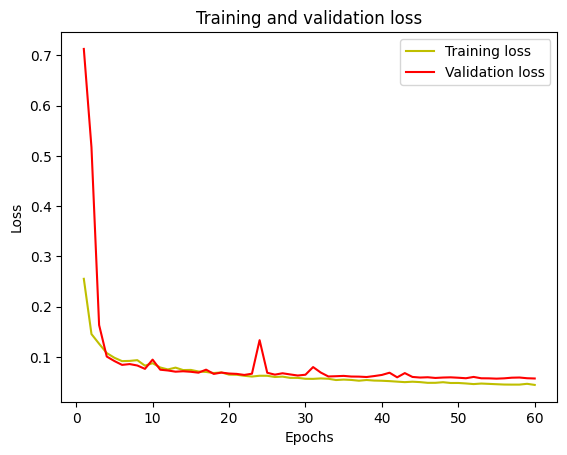

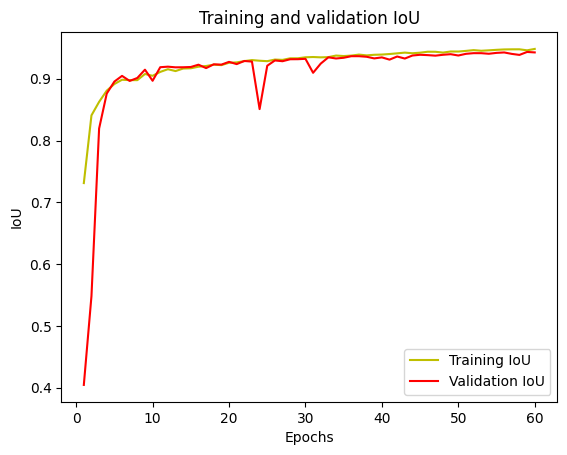

Training loss:  0.044479820877313614
Validation loss:  0.05726775527000427
Training accuracy:  0.9483202695846558
Validation accuracy:  0.942658543586731


In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
# plt.figure(figsize=(12, 8))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

print("Training loss: ",loss[-1])
print("Validation loss: ",val_loss[-1])
print("Training accuracy: ",acc[-1])
print("Validation accuracy: ",val_acc[-1])

In [ ]:
#IOU
y_pred=model_resnet_backbone.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

13/13 [==============================] - 1s 36ms/step


In [ ]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.96423316


In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
print("Random index: ",test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_resnet_backbone.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

Random index:  65
1/1 [==============================] - 0s 349ms/step


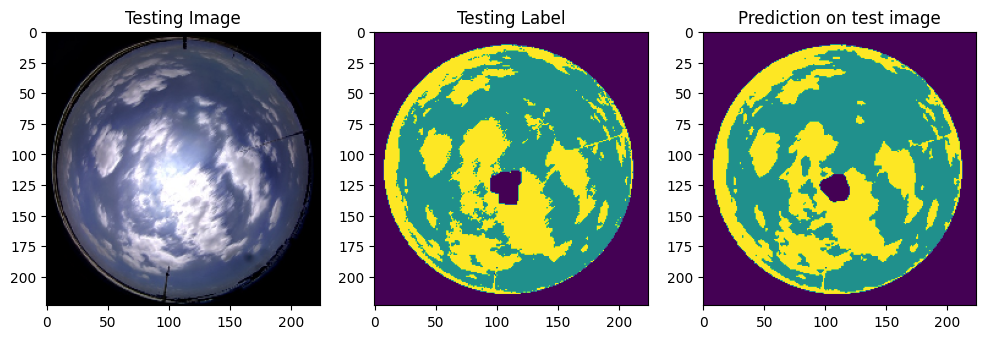

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

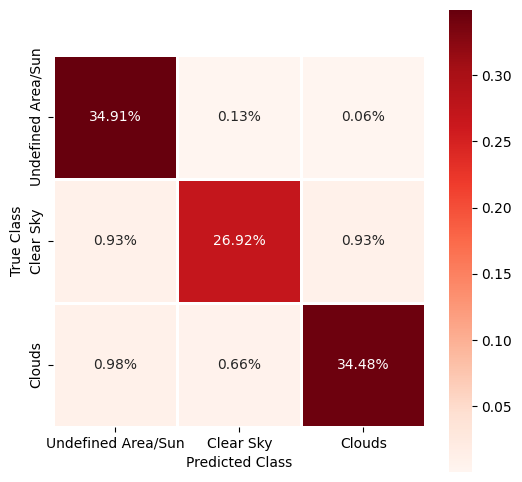

In [ ]:
import seaborn as sns

# Define the class names
class_names = ["Undefined Area/Sun", "Clear Sky", "Clouds"]

# Create a 3x3 matrix to hold the number of true positives, false positives, false negatives, and true negatives for each class
TP = [0]*3
FP = [0]*3
FN = [0]*3
TN = [0]*3

# Calculate the number of true positives, false positives, false negatives, and true negatives for each class
for i in range(3):
    FP[i] = len(np.where((y_pred_argmax == i) & (y_test[:,:,:,0] != i))[0])
    FN[i] = len(np.where((y_pred_argmax != i) & (y_test[:,:,:,0] == i))[0])
    TP[i] = len(np.where((y_pred_argmax == i) & (y_test[:,:,:,0] == i))[0])
    TN[i] = len(np.where((y_pred_argmax != i) & (y_test[:,:,:,0] != i))[0])

# Create the confusion matrix
cmat = [[TP[0], FN[0], FP[0]], [FN[1], TP[1], FN[1]], [FP[2], FN[2], TP[2]]]

plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1, linewidth=2., xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [ ]:
def crop_image2(image):
    # image = cv2.imread(input)
    r1 = image.shape[1]
    r2 = image.shape[0]
    mask = np.zeros((r2, r1), dtype=np.uint8)

    cv2.circle(mask, (int(r1/2), int(r2/2)), 570, (255, 255, 255), -1, 8, 0)

    masked = cv2.bitwise_and(image, image, mask=mask)
    cropped = masked[120:1290, 450:1620]
    return cropped

In [ ]:
def predict(img_path, model):
    image = cv2.imread(img_path)
    # test_local_img = crop_image2(image)
    test_local_img = cv2.resize(image, (224, 224),0,0, interpolation = cv2.INTER_NEAREST)
    test_local_img = cv2.cvtColor(test_local_img, cv2.COLOR_BGR2RGB)
    test_local_img = test_local_img/255.0
    masked = test_local_img
    local_test_img_input=np.expand_dims(masked, 0)
    prediction_local = (model.predict(local_test_img_input))
    local_predicted_img=np.argmax(prediction_local, axis=3)[0,:,:]
    return local_predicted_img

In [ ]:
model_resnet_backbone.save("/content/drive/MyDrive/senior/cloud segmentations/cloudSeg_model/model_resnet34_aug_b4_3e-4.h5")

In [ ]:
tf.config.list_physical_devices('GPU')
tf.device("GPU:0")

In [ ]:
pred1 = predict("/content/drive/MyDrive/senior/cloud_dataset2/2021_11_16__11_15_59_HDR_cropped.jpg", model_resnet_backbone)

1/1 [==============================] - 0s 59ms/step


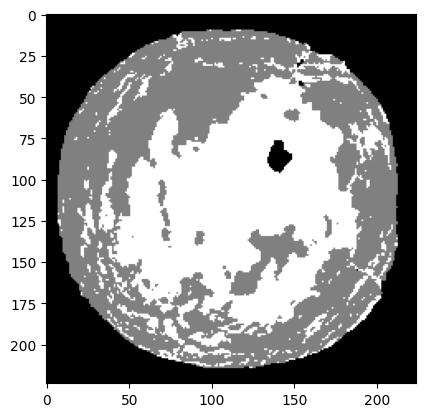

In [ ]:
plt.imshow(pred1, cmap='gray')

In [ ]:
def estimate_cloudcover(img):
    cloud_pixel = np.sum(np.array(img) == 2)
    undefine_pixel = np.sum(np.array(img) == 0)
    sky_pixel = np.sum(np.array(img) == 1)
    cloud_cover = cloud_pixel/(sky_pixel+cloud_pixel)
    # cloud_cover = cloud_pixel/(sky_pixel-cloud_pixel)
    return cloud_cover

In [ ]:
estimate_cloudcover(pred1)

0.47105545409745775